# Classificação do Coberto e Uso do Solo Português

Este notebook mostra passo por passo a criação e construção de um classificador de Solo através de técnicas de Machine Learning.

O teste vai ser feito utilizando um modelo LightGBM que classifica os pixeis de uma imagem utilizando apenas a informação desse pixel.



### Requisitos:

Para correr este notebook são precisos alguns pré requisitos:


*   Conta no Sentinel Hub webpage: https://www.sentinel-hub.com/
*   Depois de efetuar login, adicionar uma nova configuração com base no modelo de scrips Python.
*   Depois de configurar, colocar o ID de instância de configuração no arquivo de configuração do pacote do sentinelhub.

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning 
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, BBoxSplitter, CRS, DataSource

# **1.Definir a área de interesse (AOI)**




### 1.1 Obter limites do país Portugal

c:\users\vitor\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


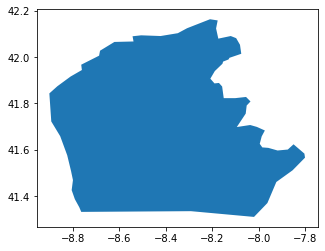

In [2]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join('data')

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'minho.json'))

country_crs = CRS.WGS84
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values[-1]

# Plot country
country.plot()
plt.axis('on');


In [3]:

(country.crs)

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 1.2 Dividir Portugal

Usou-se a função UtmZoneSplitter para definir o tamanho das bbox images (quadrados). Escolheu-se o tamanho 5000 metros que dá 500 pixels.

In [4]:
#Criou-se a divisão para se obter a lista bboxes
bbox_splitter = UtmZoneSplitter([country_shape], CRS.WGS84, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Preparar informação para as EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y}, 
                           crs=country.crs, 
                           geometry=geometry)


patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
        patchIDs.append(idx)

patchIDs = np.array(patchIDs)
        

ROWS=max([v['index_y'] for v in info_list])+1
COLUMNS=max([v['index_x'] for v in info_list])+1

In [5]:
country = country.to_crs(crs={'init': CRS.ogc_string(CRS('32629'))})
country.crs

c:\users\vitor\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Projected CRS: EPSG:32629>
Name: WGS 84 / UTM zone 29N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 12°W to 6°W - by country
- bounds: (-12.0, 0.0, -6.0, 84.0)
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

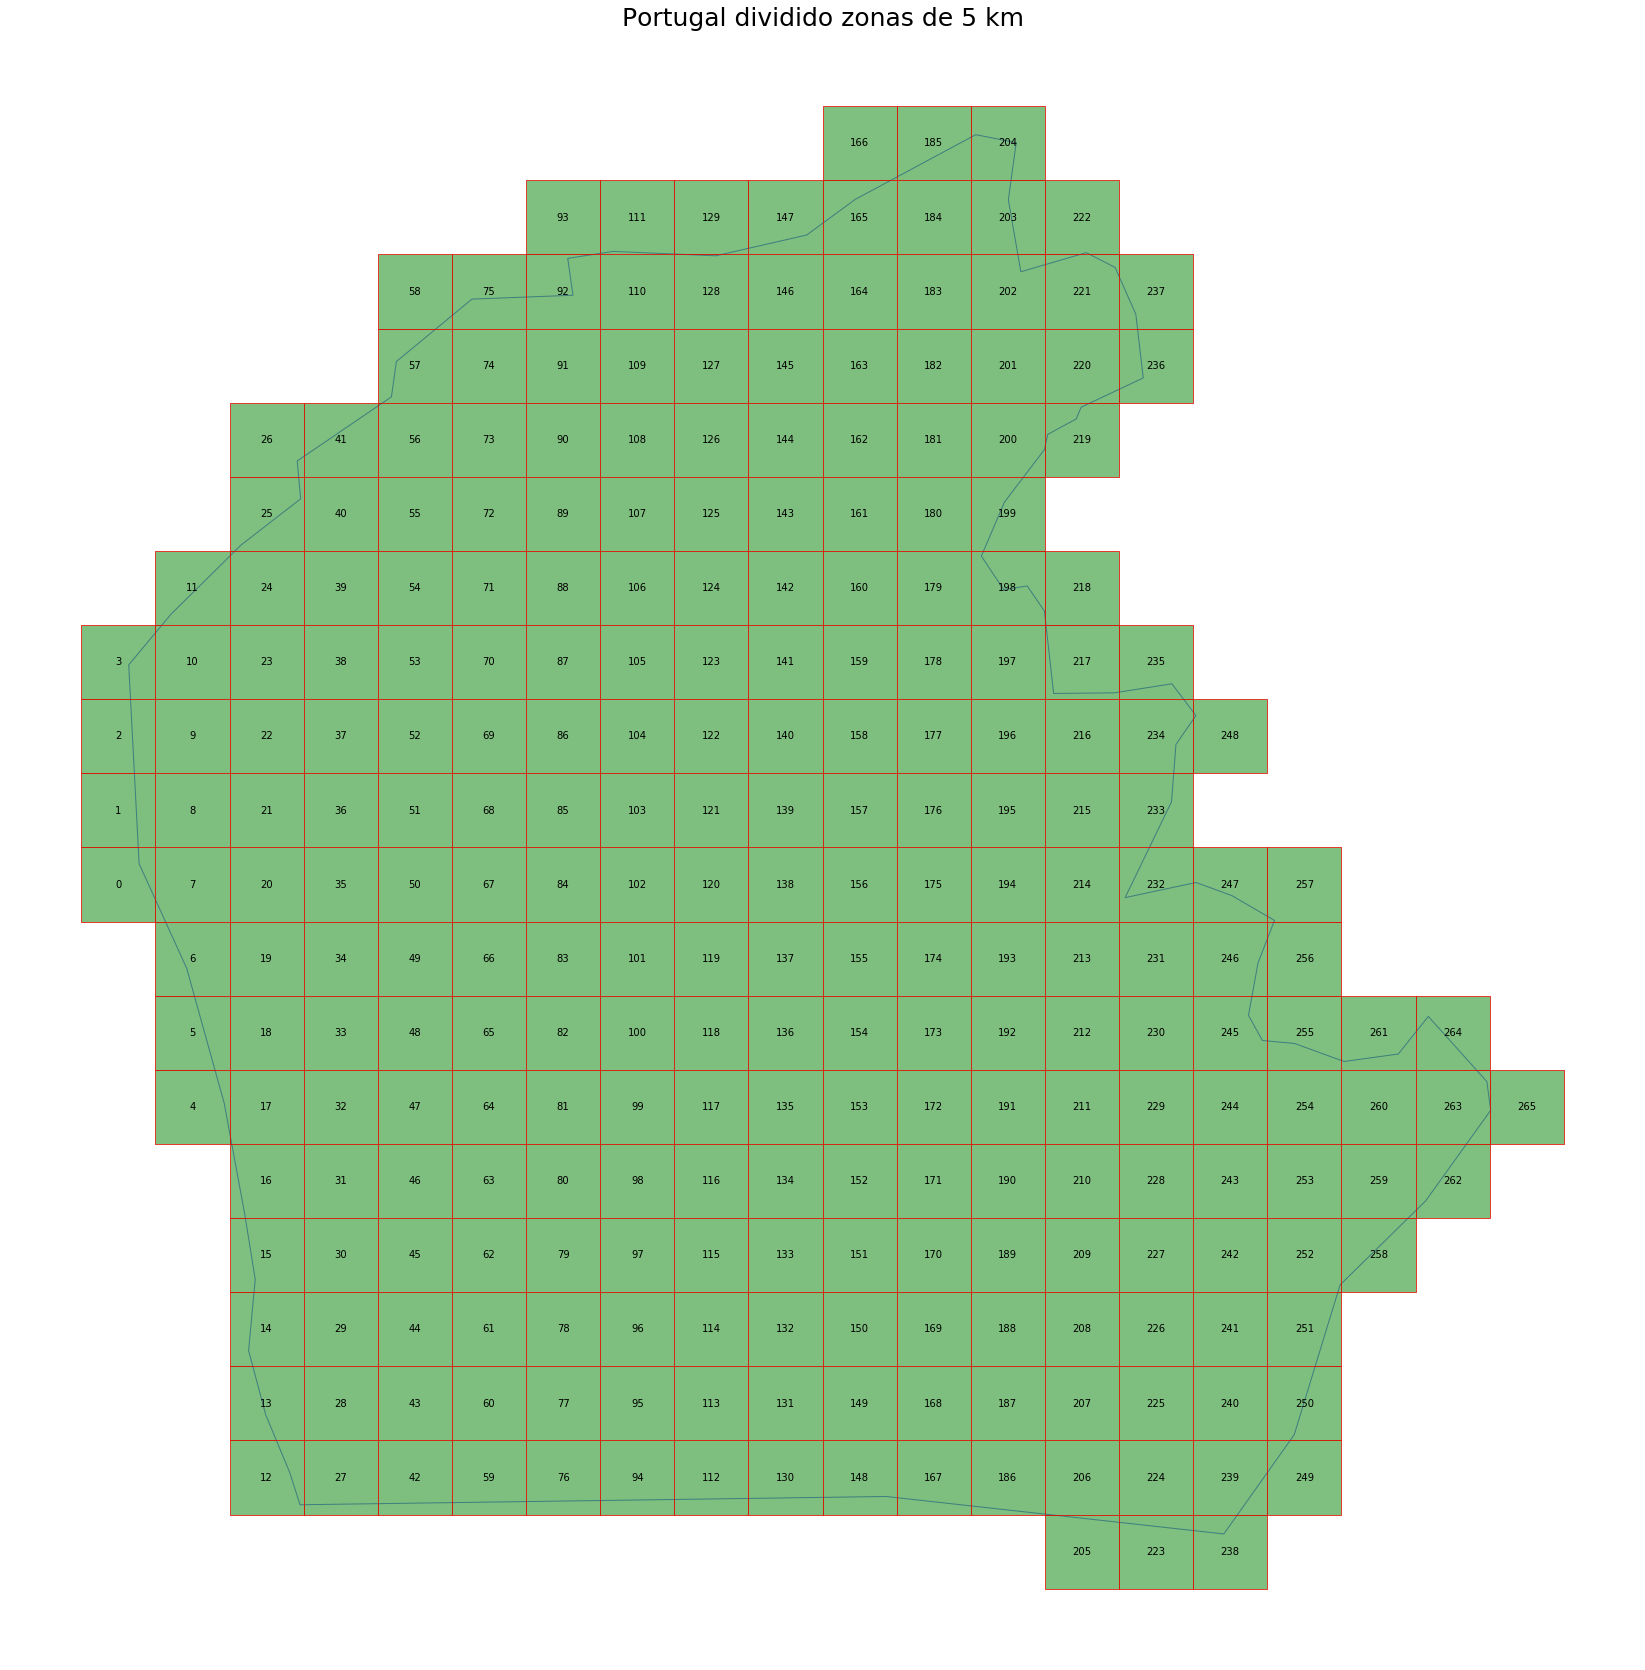

In [6]:
# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Portugal dividido zonas de 5 km', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')
    
gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

# **2. Preencher as EOPatches com dados**

O segundo passo é criar os EOPatches e preenche-los com os dados do Sentinel usando os servidores do Sentinel Hub. 

Vai-se adicionar os seguintes dados:
*   Uma lista personalizada L1C personalizada de bandas, que correspondem aos comprimentos de onda [B,G,R,NIR,SWIR1,SWIR2]
*   Uma máscara de nuvem, ou seja uma máscara que deteta as nuvens na fotografia.
*   Informações calculadas sobre NDVI, NDWI e NDBI, (indice de vegetação, índice de diferença normalizada da água,  índice acumulado de diferença normalizada), utilizados para discriminar água, vegetação irrigada e solo exposto.
*   Uma máscara de validade, com base nos dados adquiridos do Sentinel e na cobertura da nuvem. O pixél só é valido caso:
          1.  A variável IS_DATA==True.
          2.  CLOUD_MASK == 0 (1 indica que tem nuvens, 255 indica que NO_DATA e 0 que tem dados mas não tem nuvens).

### **2.1 Definir algumas EOTasks**

In [7]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch

### **2.2 Definir os workflow tasks**

In [8]:
# TASK FOR BAND DATA
# add a request for S2 bands
# Here we also do a simple filter of cloudy scenes (on tile level)
# s2cloudless masks and probabilities are requested via additional data
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(days=5),
    data_source=DataSource.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')])


# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'), 
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), 
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'), 
                                     [band_names.index('B11'), band_names.index('B08')])



# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )


# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_500/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### **2.3 Definição das classes**

*   lulcid = 1, name = artificial 
*   lulcid = 2, name = agricultura
*   lulcid = 3, name = pastagens 
*   lulcid = 4, name = agroflorestal
*   lulcid = 5, name = floresta
*   lulcid = 6, name = mato 
*   lulcid = 7, name = descoberto
*   lulcid = 8, name = humido
*   lulcid = 9, name = agua


In [9]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    ARTIFICIAL = 'Territórios Artificializados', 1,  '#dc143c'
    AGRICULTURA    = 'Agricultura',        2,  '#ffff00'
    PASTAGENS    = 'Pastagens',          3,  '#967bb6'
    AGROFLORESTAL    = 'Superfícies Agroflorestais',          4,  '#a6a6a6'
    FLORESTA             = 'Florestas',             5,  '#054907'
    MATO          = 'Matos',              6,  '#806000'
    DESCOBERTO          = 'Espaços descobertos ou com pouca vegetação',          7,  '#ffa500'
    HUMIDO            = 'Zonas Húmidas',           8,  '#95d0fc'
    AGUA              = 'Massas de água superficiais',              9,  '#069af3'
    
    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds
    


lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

In [10]:

land_use_ref_path = os.path.join(DATA_FOLDER, 'COS2018_v1/COS2018_v1.shp')
land_use_ref = gpd.read_file(land_use_ref_path)

land_use_ref.to_crs(epsg=32629,inplace=True)



In [11]:
min_x=bbox_list[patchIDs[0]].min_x
max_x=bbox_list[patchIDs[0]].max_x
min_y=bbox_list[patchIDs[0]].min_y
max_y=bbox_list[patchIDs[0]].max_y
for i in patchIDs:
    if bbox_list[i].min_x < min_x: min_x=bbox_list[i].min_x
    if bbox_list[i].max_x > max_x: max_x=bbox_list[i].max_x
    if bbox_list[i].min_y < min_y: min_y=bbox_list[i].min_y
    if bbox_list[i].max_y > max_y: max_y=bbox_list[i].max_y

coords=((min_x,max_y),
        (max_x,max_y),
        (max_x,min_y),
        (min_x,min_y),
        (min_x,max_y))

clipped_land_use_ref = gpd.clip(land_use_ref,Polygon(coords))


c:\users\vitor\appdata\local\programs\python\python37\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [12]:

clipped_land_use_ref.COS2018_n1=clipped_land_use_ref.COS2018_n1.replace(regex={r'^1.*': 1, r'^2.*': 2, r'^3.*': 3, r'^4.*': 4, r'^5.*': 5, r'^6.*': 6, r'^7.*': 7, r'^8.*': 8, r'^9.*': 9})

rasterization_task = VectorToRaster(clipped_land_use_ref, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='COS2018_n1', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint8,no_data_value=0)

### **2.4 Definir o Workflow**

As tarefas definidas até agora criam e preenchem os EOPatches.

A função abaixo vai executa-las na seguinte ordem:


1.   Criar EOPatches com os dados da banda e nuvem
2.   Calcular e adicionar os indices, NDVI, NDWI e NORM
3.   Adicionar máscara de pixels válidos
4.   Adicionar máscara com a contagem de pixels válidos
5.   Rasterização e adição do mapa de referência 
6.   Gravar as eopatches

In [13]:
# Carregar outro mapa de referencia para evitar descarregar outra vez os patches

'''
load = LoadTask('./eopatches_500')

if not os.path.isdir('./eopatches_500'):
    os.makedirs('./eopatches_500')
save = SaveTask('./eopatches_500', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

workflow = LinearWorkflow(
    load,
    rasterization_task,
    save
)


execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': f'eopatch_{idx}'},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=12, multiprocess=False)#True

executor.make_report()
'''

c:\users\vitor\appdata\local\programs\python\python37\lib\site-packages\eolearn\geometry\transformations.py:173: RuntimeWarning: Given vector polygons contain some invalid geometries, they will be fixed
  warnings.warn('Given vector polygons contain some invalid geometries, they will be fixed', RuntimeWarning)


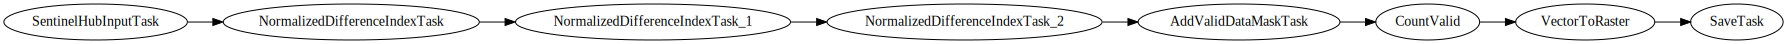

In [13]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    ndvi,
    ndwi,
    ndbi,
    add_sh_valmask,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [14]:
%%time
#Este é o passo que demora mais tempo!

# Execute the workflow
time_interval = ['2018-01-01', '2018-12-31'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()

c:\users\vitor\appdata\local\programs\python\python37\lib\site-packages\eolearn\features\bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)



Wall time: 1h 24min 18s


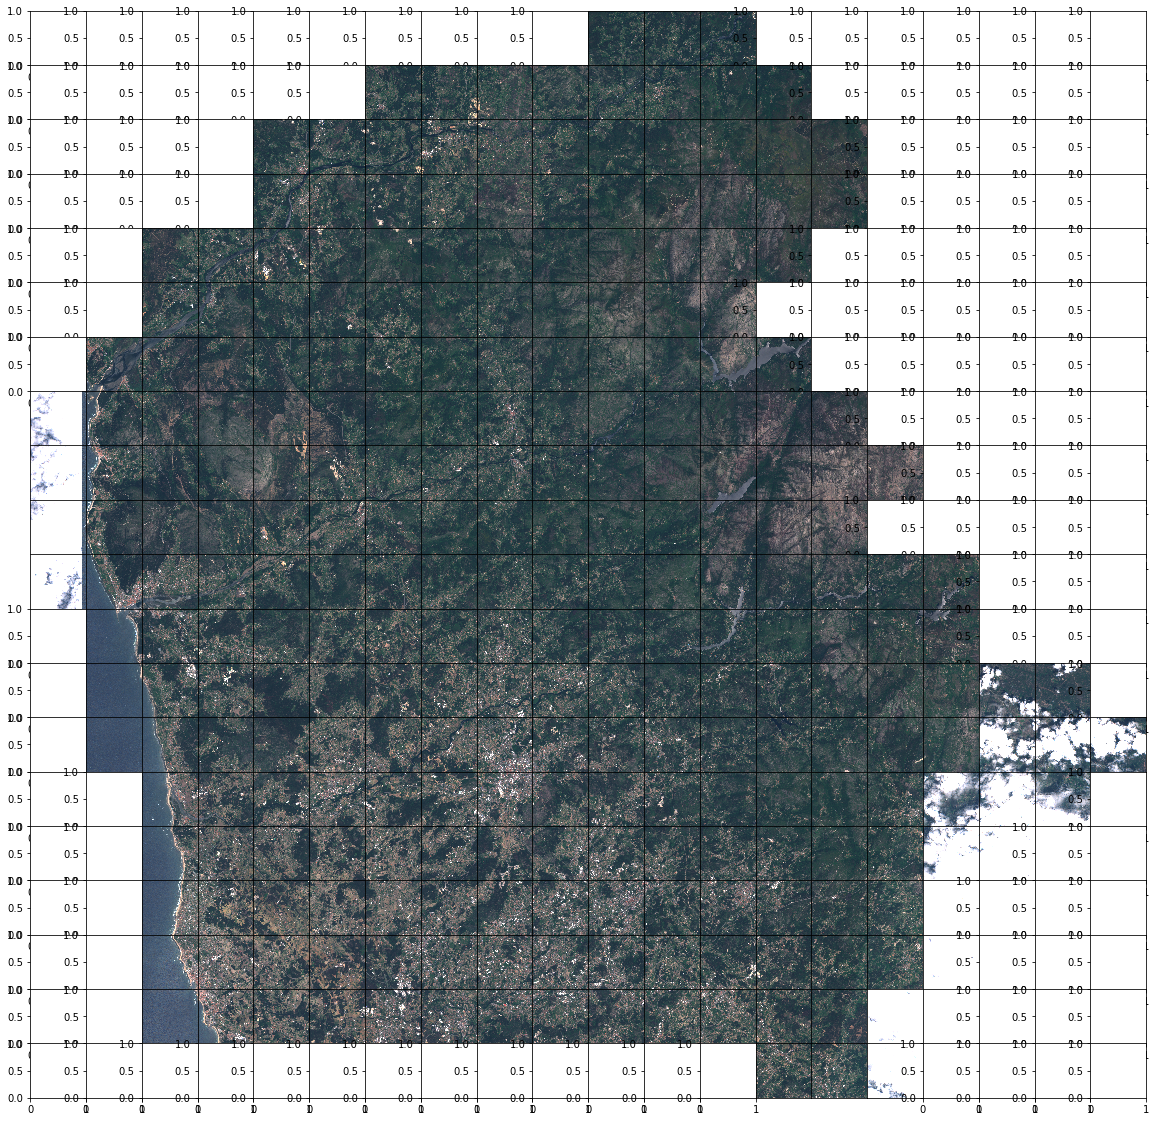

In [15]:
# Draw the RGB image
path_out = './eopatches_500'
fig, axs = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(20, 20))

date = datetime.datetime(2018,7,1)

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    #ax = axs[i//5][i%5]
    ax = axs[ROWS-1-info_list[i]['index_y']][info_list[i]['index_x']]
    dates = np.array(eopatch.timestamp)
    closest_date_id = np.argsort(abs(date-dates))[0]
    ax.imshow(np.clip(eopatch.data['BANDS'][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

Este é o resultado que se espera obter:

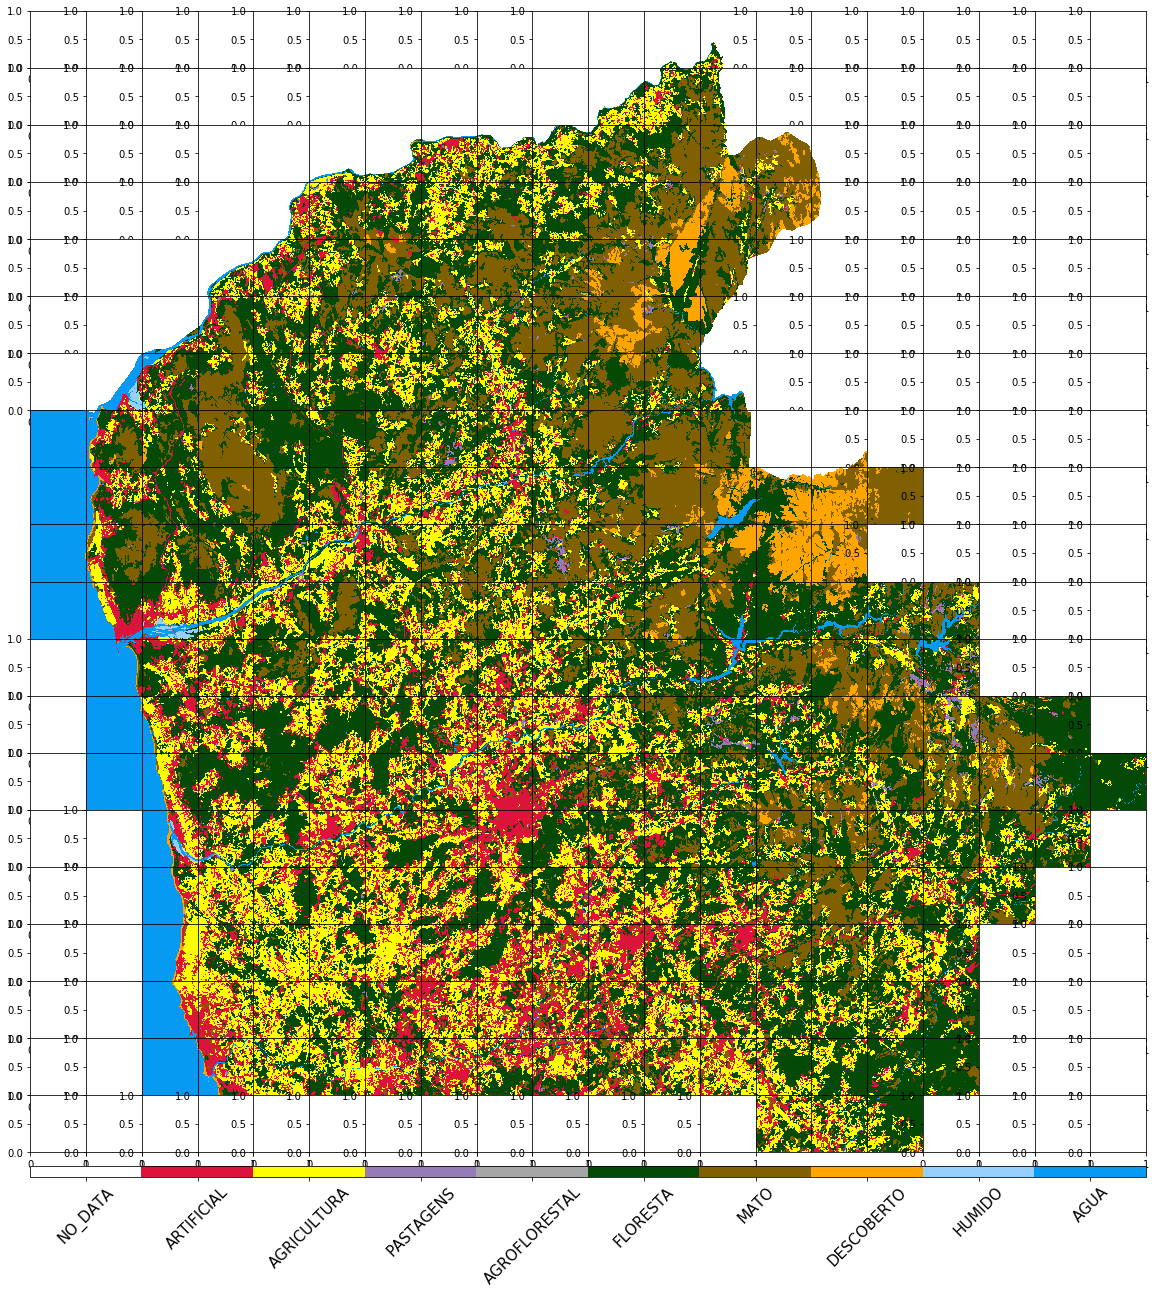

In [14]:
path_out = './eopatches_500'

fig, axs = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[ROWS-1-info_list[i]['index_y']][info_list[i]['index_x']]
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show()

### Média espacial do índice NDVI


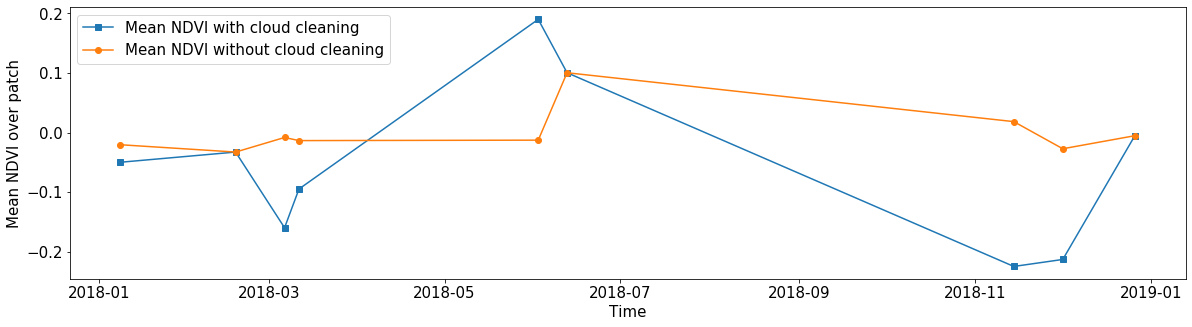

In [18]:
path_out = './eopatches_500'

eID = 16
eopatch = EOPatch.load(f'{path_out}/eopatch_{eID}', lazy_loading=True)

ndvi = eopatch.data['NDVI'] # ndvi data cube
mask = eopatch.mask['IS_VALID'] # mask of valid pixels
time = np.array(eopatch.timestamp) # x axis
t, w, h, _ = ndvi.shape 

ndvi_clean = ndvi.copy()
ndvi_clean[~mask] = np.nan # set values of invalid pixels to NaN's

# Calculate means, remove NaN's from means
ndvi_mean = np.nanmean(ndvi.reshape(t, w * h).squeeze(), axis=1) 
ndvi_mean_clean = np.nanmean(ndvi_clean.reshape(t, w * h).squeeze(), axis=1)
time_clean = time[~np.isnan(ndvi_mean_clean)]
ndvi_mean_clean = ndvi_mean_clean[~np.isnan(ndvi_mean_clean)]

fig = plt.figure(figsize=(20,5))
plt.plot(time_clean, ndvi_mean_clean, 's-', label = 'Mean NDVI with cloud cleaning')
plt.plot(time, ndvi_mean, 'o-', label='Mean NDVI without cloud cleaning')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean NDVI over patch', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc=2, prop={'size': 15});

### Média temporal do índice NDVI


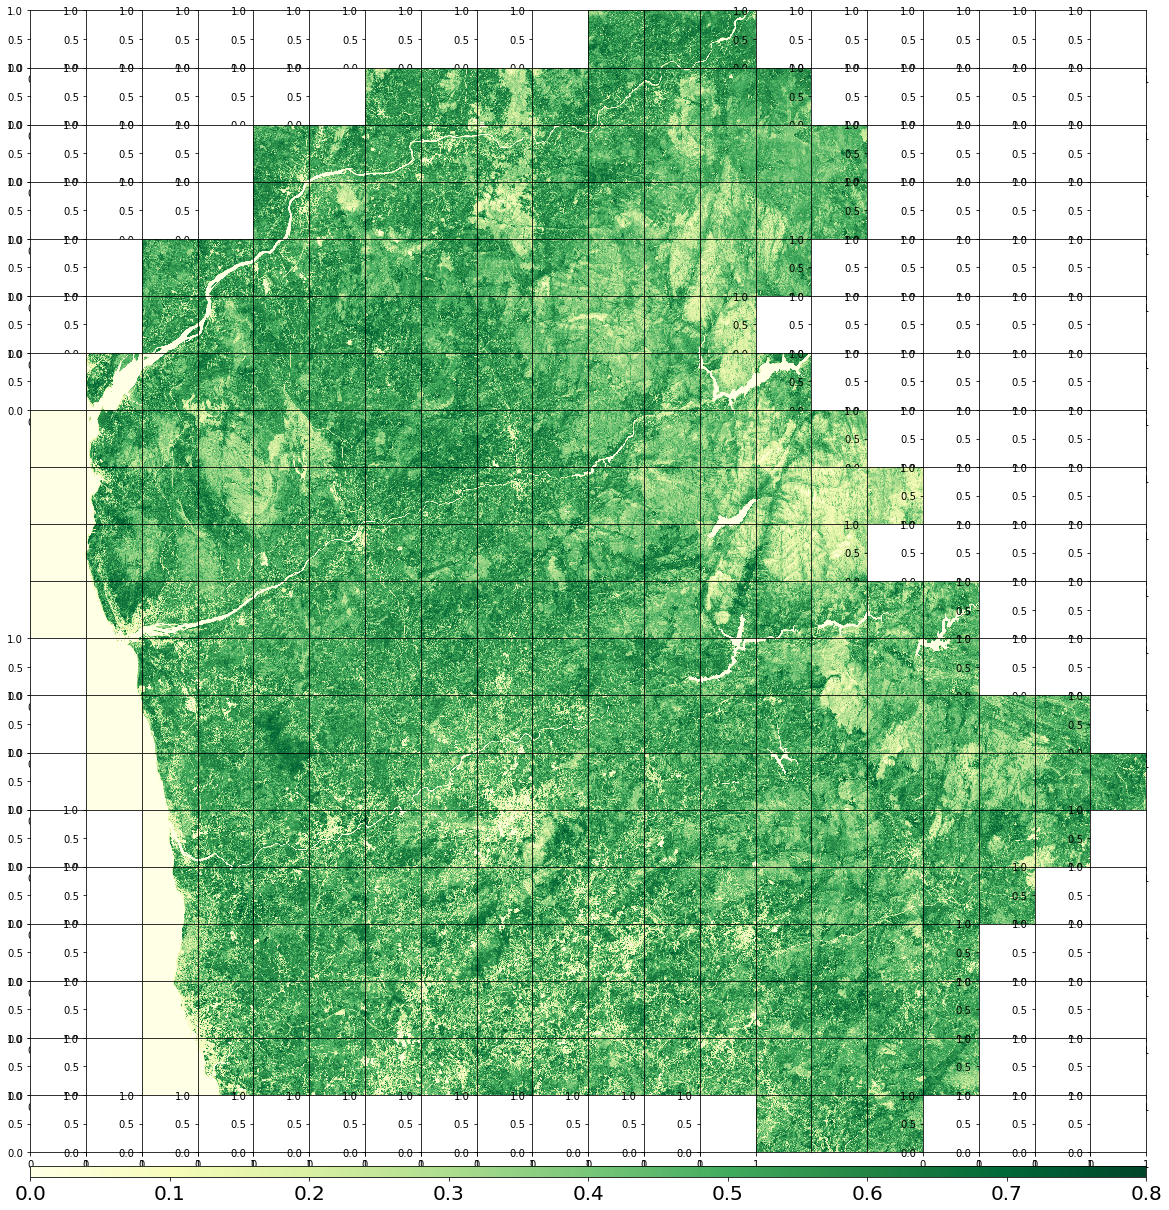

In [19]:
path_out = './eopatches_500'

fig, axs = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(20, 25))
    
for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[ROWS-1-info_list[i]['index_y']][info_list[i]['index_x']]
    ndvi = eopatch.data['NDVI']
    mask = eopatch.mask['IS_VALID']
    ndvi[~mask] = np.nan
    ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
    im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

### Média da probabilidade de nuvens

Este mapa traça a probabilidade média de haver nuvens em cada pixel, levando já em conta a máscara de nuvem. 

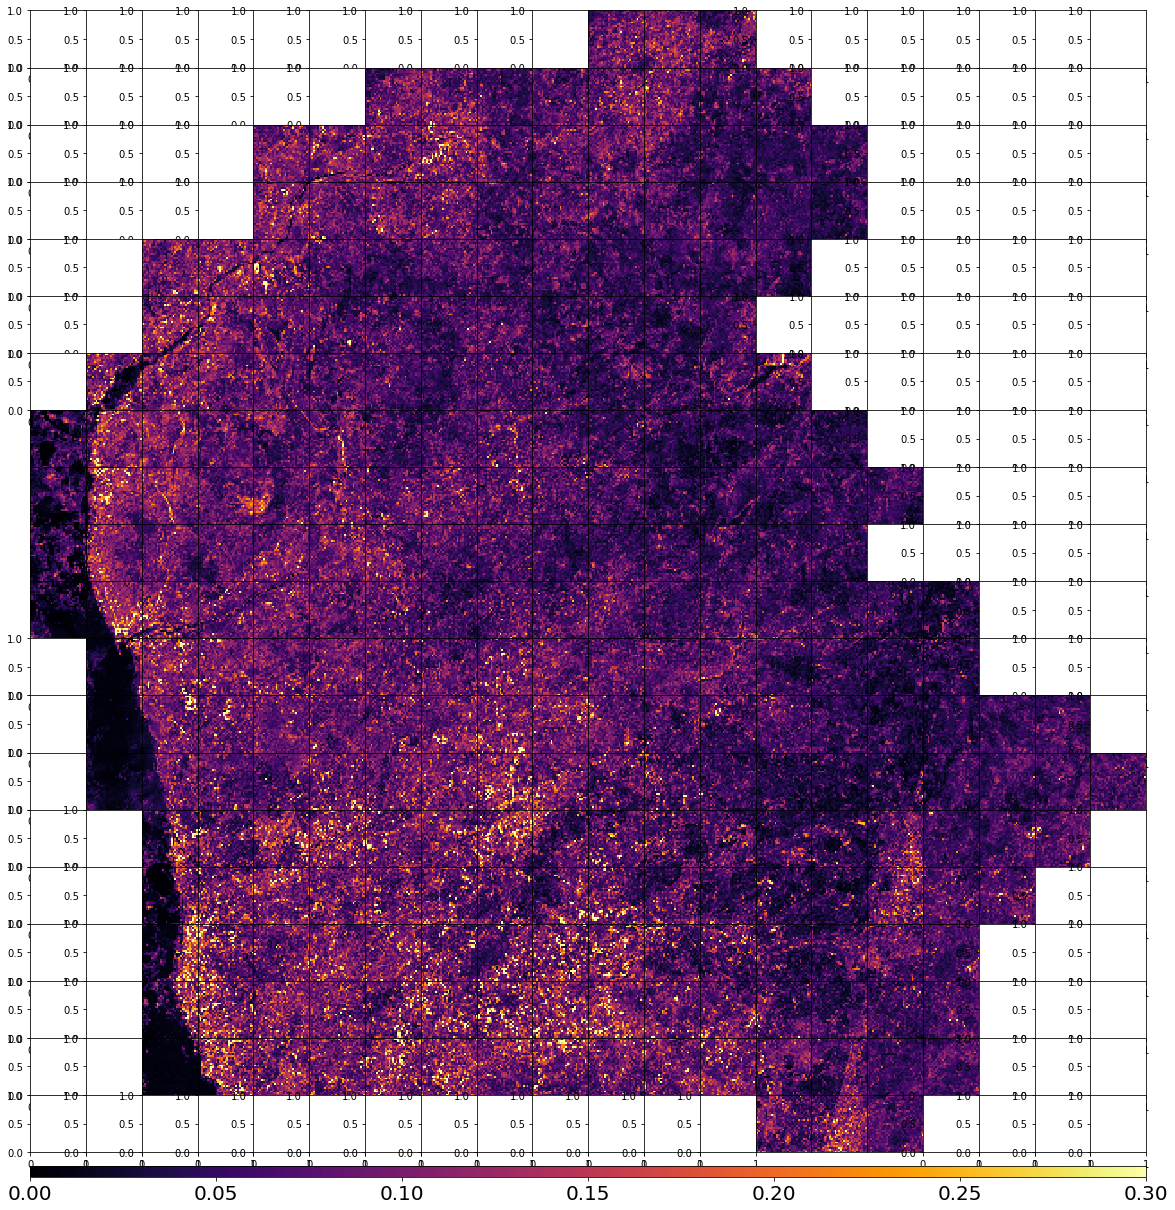

In [20]:
path_out = './eopatches_500'

fig, axs = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[ROWS-1-info_list[i]['index_y']][info_list[i]['index_x']]
    clp = eopatch.data['CLP'].astype(float)/255
    mask = eopatch.mask['IS_VALID']
    clp[~mask] = np.nan
    clp_mean = np.nanmean(clp, axis=0).squeeze()
    im = ax.imshow(clp_mean, vmin=0.0, vmax=0.3, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()


   
# **3. Preparação dos dados de treino**

Foi criado um workflow que faz o seguinte processamento:

* Junta as bandas extraídas do satélite com NDVI, NDWI e NDBI numa só feature
* Mantém apenas os períodos de tempo que têm pelo menos 80% de cobertura limpa (sem nuvens).
* Faz interpolação temporal com o objetivo de preencher espaços em branco
* Executa ErosionTask no mapa de referência para remover artefactos com largura de 1 px e remover os contornos entre os polígonos de diferentes classes
* Recolhe uma amostra aleatória de pixeis dos patches que vai ser usada para treinar e validar o modelo

In [16]:
class ValidDataFractionPredicate:

    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [17]:
class CustomSampleTask(EOTask):   
    """
    Task para efetuar amostragem de pixeis
    """
    def __init__(self, n_samples):
        self.n_samples = n_samples
        
    def execute(self, eopatch):
        
        
        pixels = len(eopatch.mask_timeless['LULC_ERODED'].flatten())
        
        samples_ID = np.random.choice(pixels,pixels-n_samples,replace=False)
        
        
        eopatch.mask_timeless['ALL_LULC_SAMPLED'] = np.delete(eopatch.mask_timeless['LULC_ERODED'].reshape(pixels,1,1),samples_ID,axis=0)
        
        
        d,_,_,f = eopatch.data['FEATURES'].shape
        eopatch.data['ALL_FEATURES_SAMPLED'] = np.delete(eopatch.data['FEATURES'].reshape(d,pixels,1,f),samples_ID,axis=1)
        


        return eopatch

In [18]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadTask(path_out)

# TASK FOR CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ['BANDS', 'NDVI', 'NDWI', 'NDBI']},
                               (FeatureType.DATA, 'FEATURES'))

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2018-02-01', '2018-11-30', 60)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
n_samples = 50000

spatial_sampling = CustomSampleTask(n_samples=n_samples)

path_out_sampled = './eopatches_sampled'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [19]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

### Correr o EOWorkflow por todas as EOPatches

In [20]:
%%time

execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': f'eopatch_{idx}'},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=12, multiprocess=False)#True

executor.make_report()


Wall time: 18min 37s


# **4. Construção do modelo**


Nesta secção é construído um modelo LightGBM para classificar as imagens de satélite. O modelo treinado irá classificar cada píxel recorrendo às features existentes nesse píxel. Neste caso cada píxel possui 9 características em 6 períodos de tempo diferentes, pelo que cada píxel será avaliado utilizando 54 features.

In [21]:
# load sampled eopatches
eopatches = []
path_out_sampled = './eopatches_sampled'

for idx in range(len(patchIDs)):
    eopatches.append(EOPatch.load(f'{path_out_sampled}/eopatch_{idx}', lazy_loading=True))    

eopatches = np.array(eopatches)

In [22]:

patch_ID = list(range(len(eopatches)))


features = np.array([eopatch.data['ALL_FEATURES_SAMPLED'] for eopatch in eopatches[patch_ID] if len(eopatch.data['ALL_FEATURES_SAMPLED'][0])!=0])
labels = np.array([eopatch.mask_timeless['ALL_LULC_SAMPLED'] for eopatch in eopatches[patch_ID] if len(eopatch.data['ALL_FEATURES_SAMPLED'][0])!=0])

p2, t, w, h, f = features.shape

features = np.moveaxis(features, 1, 3).reshape(p2 * w * h, t * f)
labels = labels.reshape(p2 * w * h, 1).squeeze()

# remove points with no reference
mask = labels == 0
features = features[~mask]
labels = labels[~mask]



In [23]:


features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, random_state=42)

# **5. Treino do Modelo**

In [24]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(labels_unique), 
    metric='multi_logloss',
    random_state=42,
    class_weight='balanced'
)

# train the model
model.fit(features_train, labels_train)
#model.fit(features_train, labels_train, sample_weight=weights)

# uncomment to save the model
joblib.dump(model, './model_SI_LULC.pkl')

Wall time: 17min 42s


['./model_SI_LULC.pkl']

# **6. Validação**

In [25]:
# load the model
model_path = './model_SI_LULC.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

## **6.1 Métricas de Validação**
A validação é baseada em várias métricas:

1.   **Accuracy** : é a medida de desempenho mais intuitiva e é simplesmente uma proporção da observação prevista corretamente com o total de observações.
2.   **Precision** : é a razão entre as observações positivas previstas corretamente e o total de observações positivas previstas.
3.   **Recall** : calcula quantos positivos o modelo captura (Verdadeiro Positivo), ou seja é a proporção entre as observações positivas previstas corretamente e todas as observações de uma classe.
4.  **$F_1$ score** : é a média ponderada de Precision e Recall, essa pontuação leva a cabo tanto os falso positivos quanto os falsos negativos.



In [26]:
class_labels = np.unique(labels_test)
class_names = [entry.name for entry in LULC]
mask = np.in1d(plabels_test, labels_test)
pred = plabels_test[mask]
lbls = labels_test[mask]

f1_scores = metrics.f1_score(lbls, pred, labels=class_labels, average=None)
recall = metrics.recall_score(lbls, pred, labels=class_labels, average=None)
precision = metrics.precision_score(lbls, pred, labels=class_labels, average=None) 

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(lbls, pred)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(lbls, pred, average='weighted')))
print()
print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

Classification accuracy 72.5%
Classification F1-score 75.4%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * ARTIFICIAL           = 74.6 |  79.9  | 69.9
         * AGRICULTURA          = 73.3 |  67.3  | 80.5
         * PASTAGENS            = 11.1 |  72.6  | 6.0
         * AGROFLORESTAL        = 4.4 |  54.5  | 2.3
         * FLORESTA             = 81.7 |  73.9  | 91.3
         * MATO                 = 61.8 |  60.3  | 63.3
         * DESCOBERTO           = 46.8 |  83.9  | 32.4
         * HUMIDO               = 11.9 |  94.3  | 6.4
         * AGUA                 = 98.9 |  98.8  | 99.0


## **6.2 Confusion Matrix e a sua transposta**

In [27]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

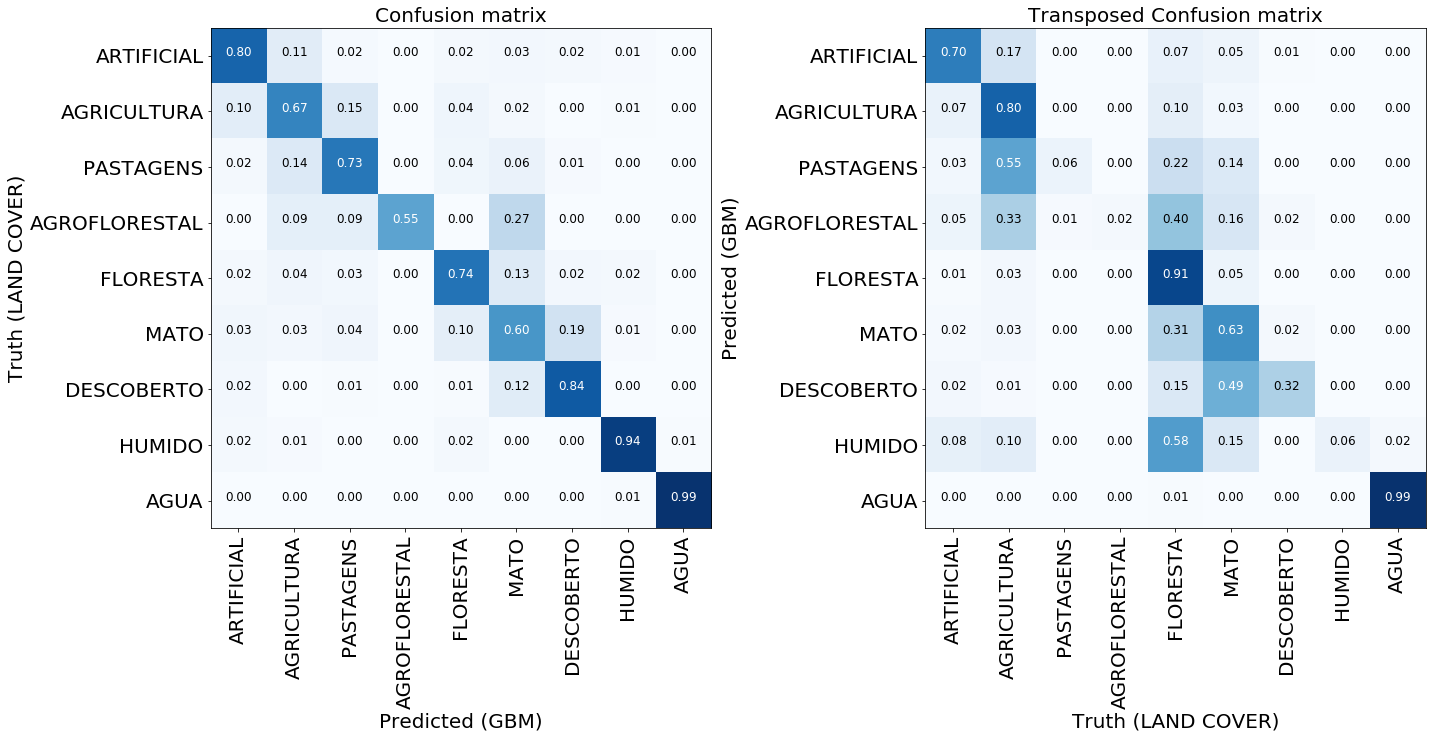

In [29]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(lbls, pred)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(pred, lbls)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (LAND COVER)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

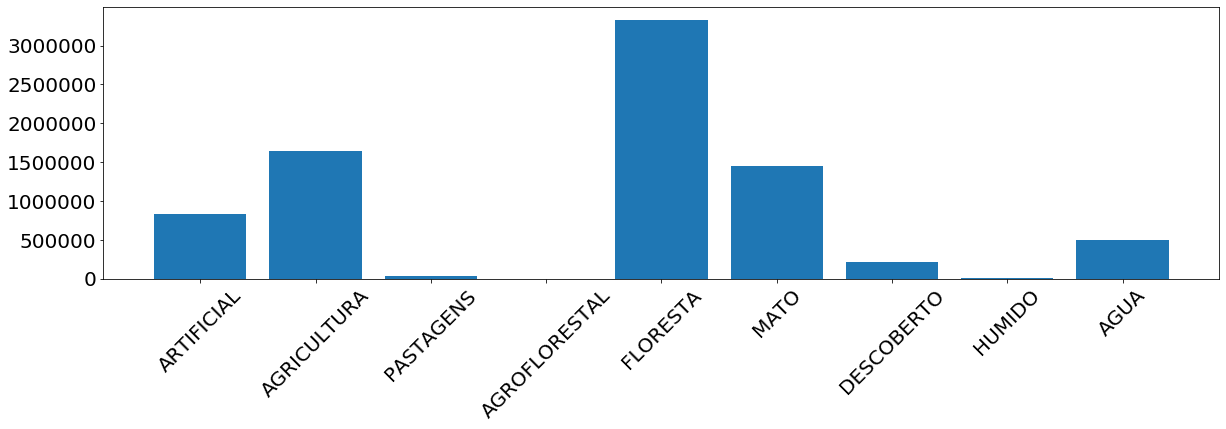

In [30]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

### Características mais importantes


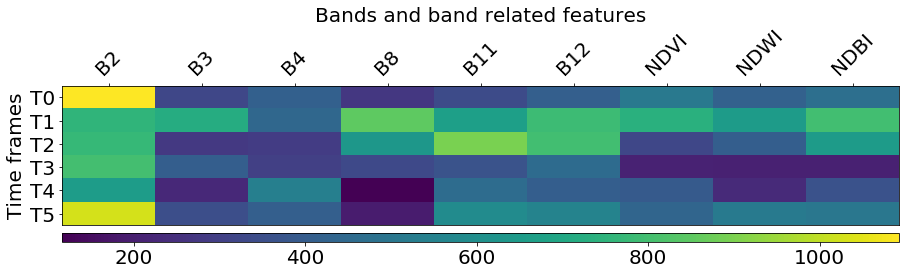

In [33]:
# names of features
fnames = ['B2','B3','B4','B8','B11','B12','NDVI','NDWI','NDBI']

# get feature importances and reshape them to dates and features
feature_importances = model.feature_importances_.reshape((t, f))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(feature_importances, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(t), [f'T{i}' for i in range(t)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 

# **7. Visualização dos Resultados**

Depois de o modelo ter sido treinado, vai ser criado um workflow para fazer a previsão para a área de interesse.

In [35]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, t * f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return eopatch

In [36]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadTask(path_out_sampled)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# TASK FOR SAVING
save = SaveTask(str(path_out_sampled), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
tiff_location = './predicted_tiff'
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)

Execução da previsão

In [37]:
# create a list of execution arguments for each patch
execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            load: {'eopatch_folder': f'eopatch_{i}'},
            export_tiff: {'filename': f'{tiff_location}/prediction_eopatch_{i}.tiff'},
            save: {'eopatch_folder': f'eopatch_{i}'}
        }
    )

# run the executor
executor = EOExecutor(workflow, execution_args)
executor.run(workers=1, multiprocess=False)
executor.make_report()

## **7.2 Visualização da Previsão**

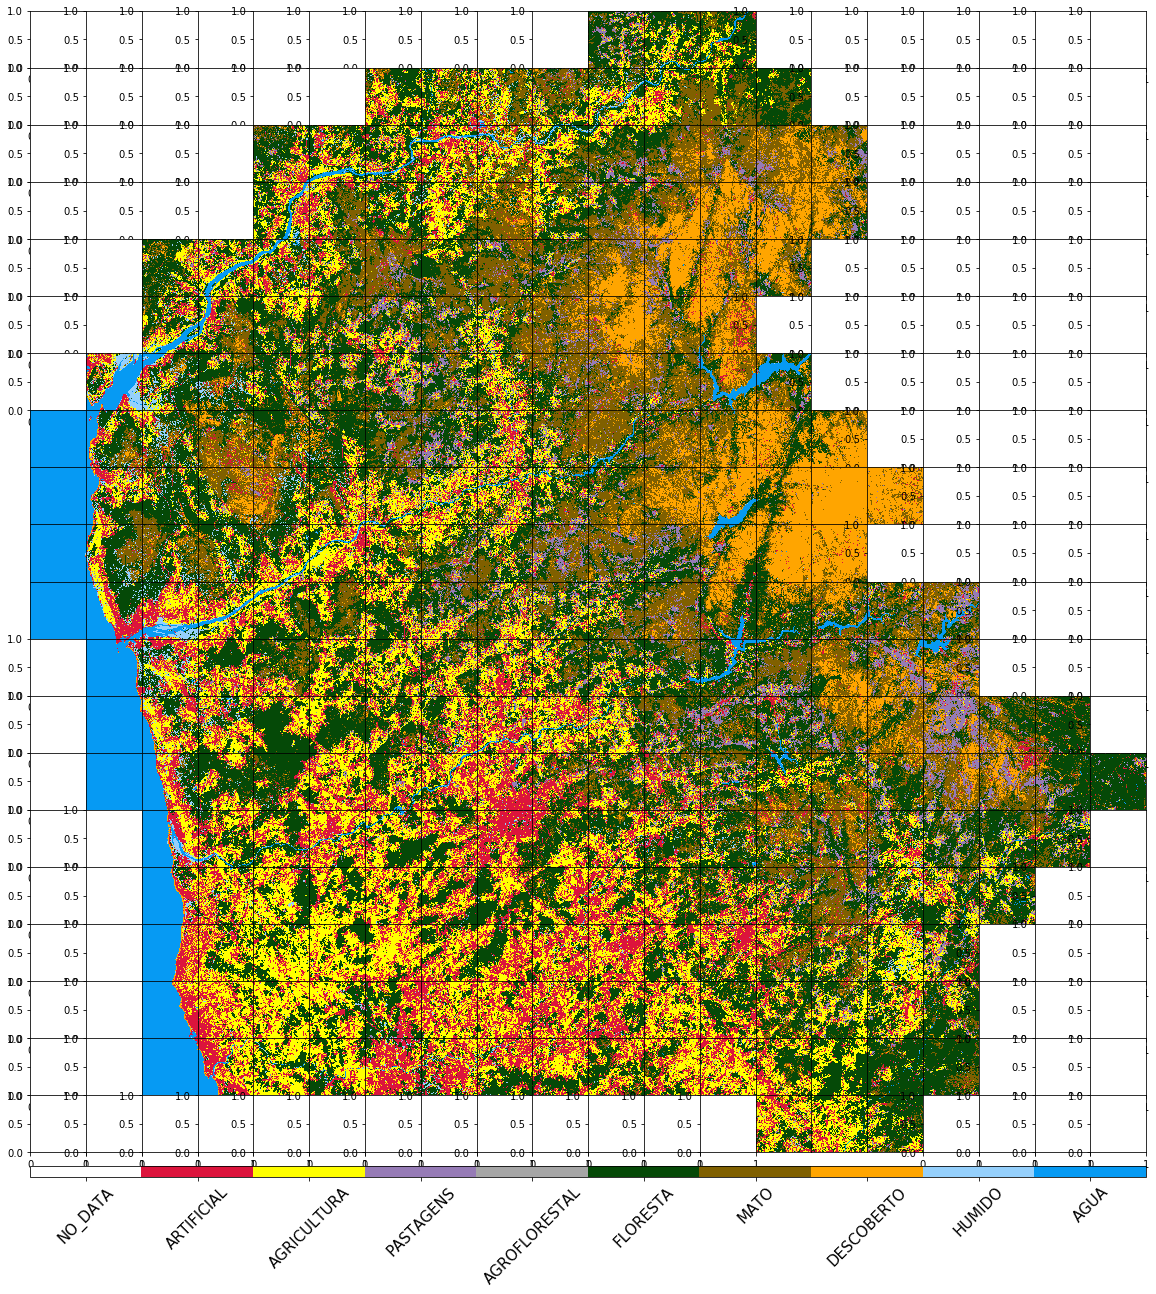

In [39]:
path_out_sampled = './eopatches_sampled'

fig, axs = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(20, 25))

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out_sampled}/eopatch_{i}', lazy_loading=True)
    ax = axs[ROWS-1-info_list[i]['index_y']][info_list[i]['index_x']]
    im = ax.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show()

## **7.3 Comparação da previsão com a realidade**

A seguir é escolhido um subconjunto de patches aleatoriamente de forma a se poder comparar e inspecionar uma parte da área de interesse de forma mais atenta e pormenorizada.

No canto superior esquerdo é mostrado o mapa com as classificações reais obtidas pelo COS e no canto superior direito temos a previsão feita pelo modelo treinado. Em baixo é apresentada a diferença entre as duas classificações e a imagem de satélite.

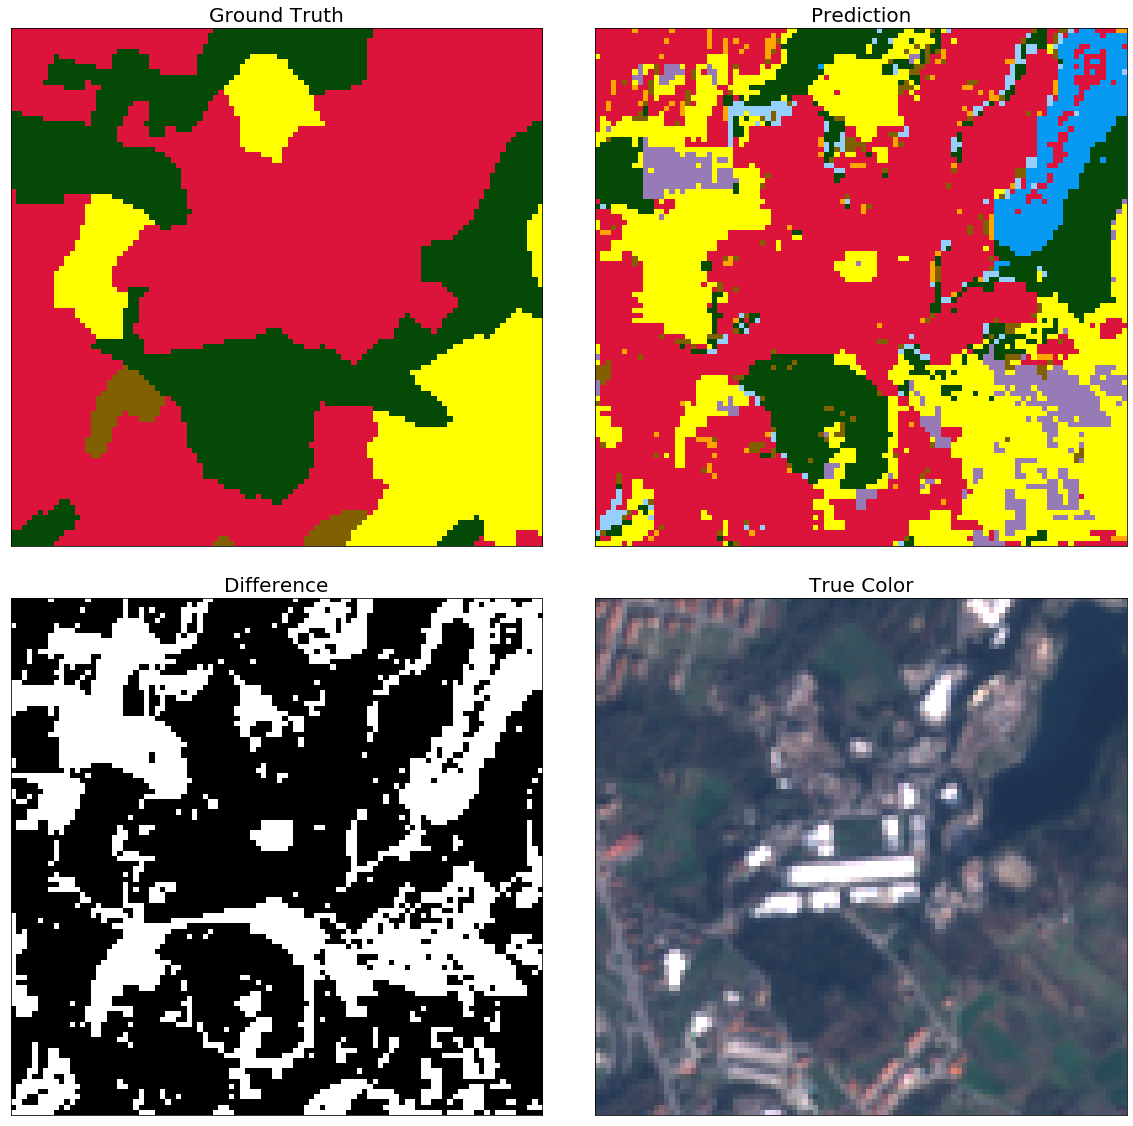

In [41]:
# Draw the Reference map
fig = plt.figure(figsize=(20, 20))

idx = np.random.choice(range(len(patchIDs)))
inspect_size = 100

eopatch = EOPatch.load(f'{path_out_sampled}/eopatch_{idx}', lazy_loading=True)

w, h = eopatch.mask_timeless['LULC'].squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
h_min = np.random.choice(range(h - inspect_size))

ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless['LULC'].squeeze()[w_min: w_min + inspect_size, h_min : h_min + inspect_size],
           cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze()[w_min: w_min + inspect_size, h_min: h_min + inspect_size],
           cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless['LBL_GBM'].squeeze() != eopatch.mask_timeless['LULC'].squeeze()
plt.imshow(mask[w_min: w_min + inspect_size, h_min: h_min + inspect_size], cmap='gray')
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('Difference', fontsize=20)

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data['FEATURES'][5][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min: w_min + inspect_size, h_min: h_min + inspect_size])
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('True Color', fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)